# Clustering / segmentation des données Olist

Maintenant que notre analyse exploratoire est faite, nous allons nous intéresser à la segmentation des données de Olist.

Commençons par définir le nombre de clusters en implémentant la méthode Elbow mais tout d'abord, démarrons par importer nos librairies :

In [8]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  
from yellowbrick.cluster import KElbowVisualizer


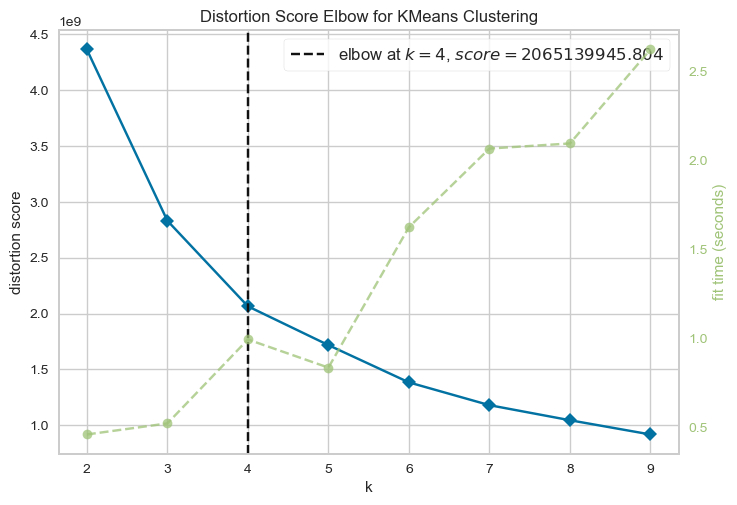

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
data = pd.read_csv("data/rfm_data.csv")

data_without_customer_review = pd.DataFrame({ "(days)last_purchase": data["(days)last_purchase"], "total_orders": data["total_orders"], "total_spend": data["total_spend"] })

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(data_without_customer_review)
visualizer.show()

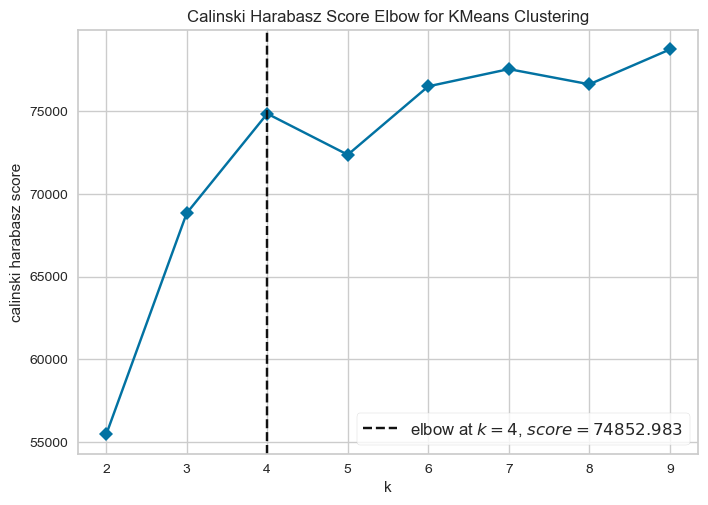

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [10]:
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,10), metric='calinski_harabasz', timings=False
)

visualizer.fit(data_without_customer_review)
visualizer.show()

D'après la méthode d'Elbow, le nombre idéal de cluster est à 4.

Implémentons notre K-Means :

In [11]:
def kmean_process(data, cluster_n, random_state, asc=False):
    data_temp = data.copy()

    kmean_model = KMeans(n_clusters=cluster_n, random_state=random_state).fit(data_temp)
    group = data.assign(cluster=kmean_model.labels_)

    group_mean = group.groupby('cluster').mean().reset_index()
    group_mean = group_mean.sort_values(by=group_mean.columns[1],ascending=asc)
    group_mean['cluster_set'] = [i for i in range(cluster_n, 0, -1) ]
    cluster_map = group_mean.set_index('cluster').to_dict()['cluster_set']

    return group['cluster'].map(cluster_map)


r_labels = kmean_process(data[['(days)last_purchase']], cluster_n=4, random_state=0, asc=True)
f_labels = kmean_process(data[['total_orders']], cluster_n=4, random_state=0)
m_labels = kmean_process(data[['total_spend']], cluster_n=4, random_state=0)

rfm_data = data.assign(R = r_labels, F = f_labels, M = m_labels) 

rfm_data.groupby('R')['(days)last_purchase'].describe()

,count,mean,std,min,25%,50%,75%,max
R,,,,,,,,
1,17391.0,483.166695,58.679148,399.0,436.0,474.0,525.0,713.0
2,25329.0,314.031308,43.420126,249.0,276.0,307.0,351.0,398.0
3,27911.0,183.363513,35.088692,123.0,154.0,183.0,214.0,248.0
4,25847.0,61.718613,35.999197,0.0,28.0,62.0,95.0,122.0


Nous voyons ici que la récurrence des commandes se situent entre 3 et 25 mois, ce qui semble assez significatif.

In [12]:
rfm_data.groupby('F')['total_orders'].describe()

,count,mean,std,min,25%,50%,75%,max
F,,,,,,,,
1,86843.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,7392.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
3,1801.0,3.274847,0.446561,3.0,3.0,3.0,4.0,4.0
4,442.0,6.045249,1.926716,5.0,5.0,6.0,6.0,21.0


Nous voyons ici que seulement 3% des consommateurs font plus d'une commande.

In [13]:
rfm_data.groupby('M')['total_spend'].describe()

,count,mean,std,min,25%,50%,75%,max
M,,,,,,,,
1,75423.0,91.111283,44.974664,9.59,53.9000,83.680,124.840,192.05
2,17798.0,293.175646,92.553771,192.07,218.6300,262.725,344.525,575.69
3,2880.0,858.470628,246.197131,575.91,659.1125,785.180,1005.810,1564.07
4,377.0,2274.673475,997.885451,1568.72,1768.4000,2026.540,2338.480,13664.08


Ici nous pouvons voir qu'en moyenne les clients dépensent environ 74$.

Essayons de regrouper nos utilisateurs dans des groupes.

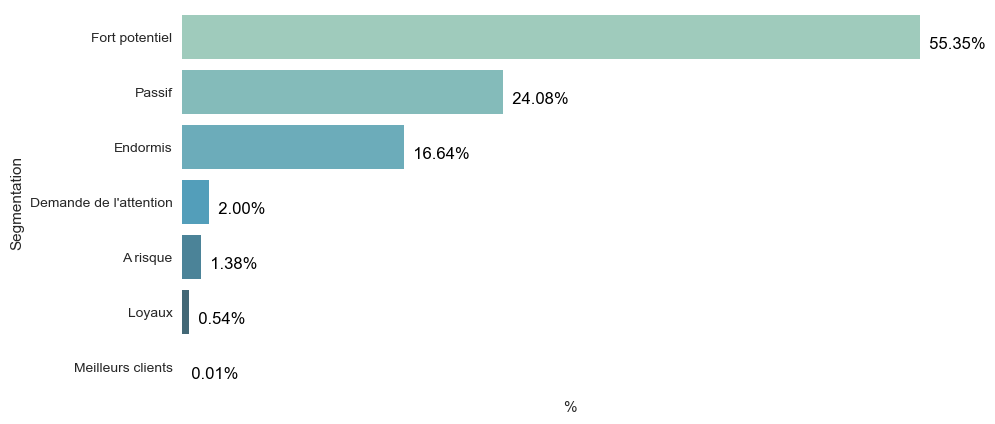

In [14]:
def segment(data):
    mean_fm = (data['F'] + data['M']) / 2

    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 4 and mean_fm <= 5):
        return 'Meilleurs clients'
    if (data['R'] >= 2 and data['R'] <= 5) and (mean_fm >= 3 and mean_fm <= 5):
        return 'Loyaux'
    if (data['R'] >= 3 and data['R'] <= 5) and (mean_fm >= 1 and mean_fm <= 3):
        return 'Fort potentiel'
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 0 and mean_fm <= 1):
        return 'Nouveau'
    if (data['R'] >= 3 and data['R'] <= 4) and (mean_fm >= 0 and mean_fm <= 1):
        return 'Prometteur'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 2 and mean_fm <= 3):
        return "Demande de l'attention"
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 0 and mean_fm <= 2):
        return 'Passif'
    if (data['R'] >= 0 and data['R'] <= 2) and (mean_fm >= 2 and mean_fm <= 5):
        return 'A risque'
    if (data['R'] >= 0 and data['R'] <= 1) and (mean_fm >= 4 and mean_fm <= 5):
        return "Bientôt Perdu"
    if (data['R'] >= 1 and data['R'] <= 2) and (mean_fm >= 1 and mean_fm <= 2):
        return 'Endormis'
    return 'Perdu'

rfm_data['segment'] = rfm_data.apply(segment, axis=1)

plt.figure(figsize=(10, 5))
percentage = (rfm_data['segment'].value_counts(normalize=True)* 100).reset_index(name='%')
g = sns.barplot(x=percentage['%'],y=percentage['index'], data=percentage,palette="GnBu_d")
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['%']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentation')
g.set(xticks=[])
plt.show()


# Conclusion

Nous pouvons observer grâce à notre classification Kmeans :

- Une part significative de clients ne passe qu'une commande et disparaisse (environ 55%)
- Une autre part passe quelques commandes de temps à temps (environ 24%)

Le reste des clients est situé entre les clients bientôt perdu et les nouveaux clients.

On peut tout de même souligner le fait que les clients "fidèles" ne représentent qu'environ 3% des clients de l'entreprise. (Ce qui reste assez bas)